In [1]:
import os

# 设置默认编码为UTF-8
os.environ['PYTHONIOENCODING'] = 'utf-8'

# 加载api_key等环境变量
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Research Agent
- 目标是根据研究简报，搜集需要的上下文信息

# 提示词

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import research_agent_prompt

show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

In [3]:
from utils import show_prompt
from deep_research_from_scratch.prompts import summarize_webpage_prompt

show_prompt(summarize_webpage_prompt, "summarize_webpage_prompt")

╭─────────────────────────────────────────── summarize_webpage_prompt ────────────────────────────────────────────╮
│                                                                                                                 │
│  You are tasked with summarizing the raw content of a webpage retrieved from a web search. Your goal is to      │
│  create a summary that preserves the most important information from the original web page. This summary will   │
│  be used by a downstream research agent, so it's crucial to maintain the key details without losing essential   │
│  information.                                                                                                   │
│                                                                                                                 │
│  Here is the raw content of the webpage:                                                                        │
│                                                                                                                 │
│  <webpage_content>                                                                                              │
│  {webpage_content}                                                                                              │
│  </webpage_content>                                                                                             │
│                                                                                                                 │
│  Please follow these guidelines to create your summary:                                                         │
│                                                                                                                 │
│  1. Identify and preserve the main topic or purpose of the webpage.                                             │
│  2. Retain key facts, statistics, and data points that are central to the content's message.                    │
│  3. Keep important quotes from credible sources or experts.                                                     │
│  4. Maintain the chronological order of events if the content is time-sensitive or historical.                  │
│  5. Preserve any lists or step-by-step instructions if present.                                                 │
│  6. Include relevant dates, names, and locations that are crucial to understanding the content.                 │
│  7. Summarize lengthy explanations while keeping the core message intact.                                       │
│                                                                                                                 │
│  When handling different types of content:                                                                      │
│                                                                                                                 │
│  - For news articles: Focus on the who, what, when, where, why, and how.                                        │
│  - For scientific content: Preserve methodology, results, and conclusions.                                      │
│  - For opinion pieces: Maintain the main arguments and supporting points.                                       │
│  - For product pages: Keep key features, specifications, and unique selling points.                             │
│                                                                                                                 │
│  Your summary should be significantly shorter than the original content but comprehensive enough to stand       │
│  alone as a source of information. Aim for about 25-30 percent of the original length, unless the content is    │
│  already concise.                                                                                               │
│                                                                                                                 │
│  Present your summary in the following format:        

In [4]:
from utils import show_prompt
from deep_research_from_scratch.prompts import compress_research_system_prompt

show_prompt(compress_research_system_prompt, "compress_research_system_prompt")

╭──────────────────────────────────────── compress_research_system_prompt ────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant that has conducted research on a topic by calling several tools and web           │
│  searches. Your job is now to clean up the findings, but preserve all of the relevant statements and            │
│  information that the researcher has gathered. For context, today's date is {date}.                             │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  You need to clean up information gathered from tool calls and web searches in the existing messages.           │
│  All relevant information should be repeated and rewritten verbatim, but in a cleaner format.                   │
│  The purpose of this step is just to remove any obviously irrelevant or duplicate information.                  │
│  For example, if three sources all say "X", you could say "These three sources all stated X".                   │
│  Only these fully comprehensive cleaned findings are going to be returned to the user, so it's crucial that     │
│  you don't lose any information from the raw messages.                                                          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Tool Call Filtering>                                                                                          │
│  **IMPORTANT**: When processing the research messages, focus only on substantive research content:              │
│  - **Include**: All tavily_search results and findings from web searches                                        │
│  - **Exclude**: think_tool calls and responses - these are internal agent reflections for decision-making and   │
│  should not be included in the final research report                                                            │
│  - **Focus on**: Actual information gathered from external sources, not the agent's internal reasoning process  │
│                                                                                                                 │
│  The think_tool calls contain strategic reflections and decision-making notes that are internal to the          │
│  research process but do not contain factual information that should be preserved in the final report.          │
│  </Tool Call Filtering>                                                                                         │
│                                                                                                                 │
│  <Guidelines>                                                                                                   │
│  1. Your output findings should be fully comprehensive and include ALL of the information and sources that the  │
│  researcher has gathered from tool calls and web searches. It is expected that you repeat key information       │
│  verbatim.                                                                                                      │
│  2. This report can be as long as necessary to return ALL of the information that the researcher has gathered.  │
│  3. In your report, you should return inline citations for each source that the researcher found.               │
│  4. You should include a "Sources" section at the end of the report that lists all of the sources the           │
│  researcher found with corresponding citations, cited against statements in the report.                         │
│  5. Make sure to include ALL of the sources that the r

In [5]:
from utils import show_prompt
from deep_research_from_scratch.prompts import compress_research_human_message

show_prompt(compress_research_human_message, "compress_research_human_message")

╭──────────────────────────────────────── compress_research_human_message ────────────────────────────────────────╮
│                                                                                                                 │
│  All above messages are about research conducted by an AI Researcher for the following research topic:          │
│                                                                                                                 │
│  RESEARCH TOPIC: {research_topic}                                                                               │
│                                                                                                                 │
│  Your task is to clean up these research findings while preserving ALL information that is relevant to          │
│  answering this specific research question.                                                                     │
│                                                                                                                 │
│  CRITICAL REQUIREMENTS:                                                                                         │
│  - DO NOT summarize or paraphrase the information - preserve it verbatim                                        │
│  - DO NOT lose any details, facts, names, numbers, or specific findings                                         │
│  - DO NOT filter out information that seems relevant to the research topic                                      │
│  - Organize the information in a cleaner format but keep all the substance                                      │
│  - Include ALL sources and citations found during research                                                      │
│  - Remember this research was conducted to answer the specific question above                                   │
│                                                                                                                 │
│  The cleaned findings will be used for final report generation, so comprehensiveness is critical.               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# 定义state和schemas

In [6]:
%%writefile deep_research_from_scratch/state_research.py

"""定义用于Research Agent的state和pydantic的schemas"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ==== 定义state ====

class ResearcherState(TypedDict):
    """用于存储上下文信息"""
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """用于存储Research Agent的输出"""
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ==== 定义schemas ====

class ClarifyWithUser(BaseModel):
    """scoping澄清阶段的schema定义"""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question."
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information."
    )

class ResearchQuestion(BaseModel):
    """用于生成研究简报的schema定义"""
    research_brief: str = Field(
        description="A research question that will be used to guide the research."
    )

class Summary(BaseModel):
    """用于网页内容总结的schema定义"""
    summary: str = Field(
        description="Concise summary of the webpage content"
    )
    key_excerpts: str = Field(
        description="Important quotes and excerpts from the content"
    )

Overwriting deep_research_from_scratch/state_research.py


# 定义tools

In [7]:
%%writefile deep_research_from_scratch/utils.py

"""Research工具定义"""

import os
from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

from deep_research_from_scratch.state_research import Summary
from deep_research_from_scratch.prompts import summarize_webpage_prompt

# ==== 常用函数定义 ====

def get_today_str() -> str:
    """获取当前日期字符串"""
    # 使用#代替-,避免跨平台问题
    return datetime.now().strftime("%a %b %#d, %Y")

def get_current_dir() -> Path:
    """获取当前模块的所在目录"""
    try:
        return Path(__file__).resolve().parent
    except NameError:
        return Path.cwd()

# ==== 配置 ====

# 初始化gpt模型
api_url = os.getenv('KIMI_API_URL')
api_key = os.getenv('KIMI_API_KEY')
model_name = os.getenv('KIMI_MODEL')
summarization_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=64000
)
# 初始化tavily客户端
tavily_client = TavilyClient()

# ==== 搜索功能相关函数定义 ====

def tavily_search_multiple(
    search_queries: List[str],
    max_results: int = 3,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = True,
) -> List[dict]:
    """
    使用tavily搜索多个查询
    
    Args:
        search_queries: 搜索查询列表
        max_results: 每个查询的最大结果数
        topic: 搜索主题
        include_raw_content: 是否包含原始网页内容
    Returns:
        List[dict]: 搜索结果列表, 每个结果包含url, title, snippet, raw_content
    """
    # 依次进行搜索（也可以使用AsyncTavilyClient进行并发搜索）
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic,
        )
        search_docs.append(result)
    
    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """
    使用LLM对网页内容进行总结和要点摘录
    
    Args:
        webpage_content: 网页内容
    Returns:
        str: 总结
    """
    try:
        # 设置结构化的输出
        structured_model = summarization_model.with_structured_output(Summary)

        # 生成总结和要点摘录
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content,
                date=get_today_str()
            ))
        ])
        
        # 格式化总结和要点摘录
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )

        return formatted_summary
        
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
    
def deduplicate_search_results(search_results: List[dict]) -> dict:
    """根据url去重"""
    unique_results = {}

    for response in search_results:
        for result in response["results"]:
            url = result["url"]
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """
    处理搜索结果

    Args:
        unique_results: 去重后的搜索结果
    Returns:
        dict: 处理后的搜索结果
    """
    summarized_results = {}

    for url, result in unique_results.items():
        if not result.get("raw_content"):
            content = result["content"]
        else:
            # 总结内容
            content = summarize_webpage_content(result["raw_content"])
        
        summarized_results[url] = {
            "title": result["title"],
            "content": content,
        }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """
    格式化搜索结果

    Args:
        summarized_results: 处理后的搜索结果
    Returns:
        str: 格式化后的搜索结果
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"

    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i} {result["title"]} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result["content"]}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

# ==== 定义tools ====

# 搜索工具
@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # 单次搜索
    search_results = tavily_search_multiple(
        [query],
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # 结果去重
    unique_results = deduplicate_search_results(search_results)

    # 总结页面内容
    summarized_results = process_search_results(unique_results)

    # 格式化搜索结果
    formatted_output = format_search_output(summarized_results)

    return formatted_output

# 反思工具
# 有意思的是，反思工具的功能是通过docstring的描述定义的（效果类似于prompt）
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """

    return f"Reflection recorded: {reflection}"


Overwriting deep_research_from_scratch/utils.py


# 定义工作流

In [8]:
%%writefile deep_research_from_scratch/research_agent.py

"""实现Research Agent，通过多次搜索和整合回答研究问题"""

import os
from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message

# ==== 配置 ====

# 工具设置
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# 初始化模型
api_url = os.getenv('KIMI_API_URL')
api_key = os.getenv('KIMI_API_KEY')
model_name = os.getenv('KIMI_MODEL')
model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    # max_tokens=64000
)
# 工具绑定
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    # max_tokens=64000
)
compress_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    # max_tokens=64000
)

# ==== agent节点 ====

def llm_call(state: ResearcherState):
    """后续action的判断
    
    根据当前的对话内容，判断后续的action：
    1. 如果需要继续搜索，则调用tavily_search工具
    2. 根据收集到的信息，给出最终回答
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """工具执行"""
    tool_calls = state["researcher_messages"][-1].tool_calls

    # 执行工具
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
    
    # 工具调用的输出结果
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"],
        ) for observation, tool_call in zip(observations, tool_calls)
    ]

    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """压缩research相关的信息"""
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    used_compress_research_human_message = compress_research_human_message
    if state.get("research_topic", ""):
        used_compress_research_human_message = used_compress_research_human_message.format(
            research_topic=state.get("research_topic")
        )
    messages = [SystemMessage(content=system_message)] \
        + state.get("researcher_messages", []) \
        + [HumanMessage(content=used_compress_research_human_message)]
    response = compress_model.invoke(messages)

    # 保留原始工具调用信息和LLM的输出
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"],
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ==== 路由逻辑 ====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """根据当前的对话内容，判断是否需要继续research的循环"""
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # 如果最后一条消息是tool_message，则继续research
    if last_message.tool_calls:
        return "tool_node"
    return "compress_research"

# ==== 定义graph ====

# 创建agent的工作流
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# 添加节点
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# 添加边（edges）
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,  # 判断条件
    {
        "tool_node": "tool_node",
        "compress_research": "compress_research",
    }
)
agent_builder.add_edge("tool_node", "llm_call")
agent_builder.add_edge("compress_research", END)

# 编译
researcher_agent = agent_builder.compile()

Overwriting deep_research_from_scratch/research_agent.py


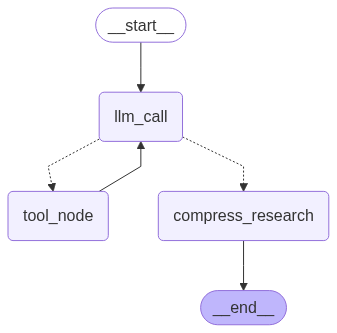

In [9]:
from IPython.display import Image, display
from deep_research_from_scratch.research_agent import researcher_agent

# 可视化工作流
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

# 运行工作流（测试）

In [10]:
from utils import format_messages
from langchain_core.messages import HumanMessage

# 研究简报示例
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}")]})
format_messages(result["researcher_messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you identify and evaluate the best coffee shops in San Francisco based specifically on coffee         │
│ quality. Let me start by searching for the most current and comprehensive information about top-rated coffee    │
│ shops in SF, focusing on expert reviews and quality assessments.                                                │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops San Francisco 2025 coffee quality expert reviews specialty coffee"                │
│ }                                                                                                               │
│    ID: tavily_search:0                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 Coffee Shops San Francisco, CA - Last Updated September 2025 ---                                   │
│ URL: https://www.yelp.com/search?find_desc=Coffee+Shops&find_loc=San+Francisco%2C+CA                            │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ 1. The Coffee Movement. 4.6 (231 reviews). 2.5 mi. 1737 Balboa St, San Francisco, CA 94121 · 2. Paper Son       │
│ Coffee. 4.6 (53 reviews). 2.8 mi. 303 2nd St N102, San                                                          │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2 THE BEST Coffee & Tea in San Francisco - Tripadvisor ---                                           │
│ URL: https://www.tripadvisor.com/Restaurants-g60713-zfg9900-San_Francisco_California.html                       │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ 1. Cafe De Casa. 4.7. (211 reviews). Coffee & Tea, Brazilian$ · 2. Blue Bottle Coffee. 4.5. (609 reviews) · 3.  │
│ Caffe Trieste. 4.2. (348                                                                                        │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3 16 Best Coffee Shops In San Francisco - Tasting Table ---                                          │
│ URL: https://www.tastingtable.com/1479970/best-coffee-shops-san-francisco/                                      │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This comprehensive guide presents 16 of the best coffee shops in San Francisco, curated by a local expert. The  │
│ list spans from popular chains like Blue Bottle Coffee and Philz Coffee to unique independent cafes, each       │
│ distinguished by their commitment to quality and sustainable sourcing. Notable highlights include Compton's     │
│ Coffee House with its famous $3 Americano and Lavender Latte, Red Bay Coffee's Ferry Building location focusing │
│ on diversifying coffee production, and Ritual Coffee's 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "From this initial search, I have some good starting points with mentions of several notable    │
│ coffee shops like The Coffee Movement, Blue Bottle, Ritual Coffee, Sightglass, and Andytown. However, these     │
│ sources are more general and don't provide the specific coffee quality assessments I need. I need to find more  │
│ detailed expert reviews and specialty coffee certifications. Let me search for more specific information about  │
│ coffee quality ratings, expert reviews from organizations like Coffee Review, and specialty coffee              │
│ certifications."                                                                                                │
│ }                                                                                                               │
│    ID: think_tool:1                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: From this initial search, I have some good starting points with mentions of several        │
│ notable coffee shops like The Coffee Movement, Blue Bottle, Ritual Coffee, Sightglass, and Andytown. However,   │
│ these sources are more general and don't provide the specific coffee quality assessments I need. I need to find │
│ more detailed expert reviews and specialty coffee certifications. Let me search for more specific information   │
│ about coffee quality ratings, expert reviews from organizations like Coffee Review, and specialty coffee        │
│ certifications.                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "San Francisco coffee shops Coffee Review ratings 2025 specialty coffee quality scores"              │
│ }                                                                                                               │
│    ID: tavily_search:2                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 Best Coffee San Francisco, CA - Last Updated September 2025 - Yelp ---                             │
│ URL: https://m.yelp.com/search?find_desc=best+coffee&find_loc=San+Francisco%2C+CA                               │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Paper Son Coffee. 4.5 (55 reviews) 2.8 mi.                                                                      │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2 TOP 10 BEST Specialty Coffee near South San Francisco, CA - Yelp ---                               │
│ URL: https://m.yelp.com/search?find_desc=Specialty+Coffee&find_loc=South+San+Francisco%2C+CA                    │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Best Specialty Coffee near South San Francisco, CA ; 1. Dead Eye Coffee Bar · (415 reviews). 0.6 mi ; 2. Spruce │
│ Cafe · (639 reviews). 0.4 mi ; 3. Specialty's Cafe &                                                            │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3 San Francisco Coffee Ratings and Reviews ---                                                       │
│ URL: https://www.coffeereview.com/best-coffee-cities/san-francisco/                                             │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This webpage presents 261 coffee and espresso reviews from San Francisco roasters, listed in reverse            │
│ chronological order. The most recent reviews from 2025 include:                                                 │
│                                                                                                                 │
│ **Recent High-Scoring Coffees (2025):**                                                                         │
│ - Owl's Howl Espresso Blend (Sightglass Coffee) - 93 points, $20/12oz                                           │
│ - Ethiopia Fancy (Peet's Coffee & Tea) - 93 points, $19

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "This Coffee Review data is excellent! I now have specific quality scores from a reputable      │
│ expert source. I can see that Equator Coffees, Sightglass Coffee, Chromatic Coffee, and others are receiving    │
│ high ratings (91-95 points). However, I need to connect these roasters to their actual coffee shop locations in │
│ San Francisco, and also gather more recent customer feedback. Let me search for more specific information about │
│ the top-rated coffee shops and their physical locations, along with any specialty certifications or awards."    │
│ }                                                                                                               │
│    ID: think_tool:3                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: This Coffee Review data is excellent! I now have specific quality scores from a reputable  │
│ expert source. I can see that Equator Coffees, Sightglass Coffee, Chromatic Coffee, and others are receiving    │
│ high ratings (91-95 points). However, I need to connect these roasters to their actual coffee shop locations in │
│ San Francisco, and also gather more recent customer feedback. Let me search for more specific information about │
│ the top-rated coffee shops and their physical locations, along with any specialty certifications or awards.     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "\"Equator Coffees\" \"Sightglass Coffee\" \"Chromatic Coffee\" San Francisco locations 2025         │
│ specialty coffee shops"                                                                                         │
│ }                                                                                                               │
│    ID: tavily_search:4                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 Best Specialty Coffee Shops in California | Coffeeopia ---                                         │
│ URL: https://coffeeopia.com/places/united-states/california                                                     │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This webpage presents a comprehensive directory of coffee shops and roasters located in California. The list    │
│ includes over 200 establishments ranging from well-known national chains like Blue Bottle Coffee, La Colombe,   │
│ and Philz Coffee to local favorites such as Verve Coffee Roasters, Ritual Coffee Roasters, and Sightglass       │
│ Coffee. The directory covers various types of coffee businesses including specialty roasters, espresso bars,    │
│ coffee houses, and cafes with multiple locations across the state. Notable mentions include Andytown Coffee     │
│ Roasters, Augie's Coffee Roasters, Bird Rock Coffee Roasters, and Temple Coffee Roasters, which appear to have  │
│ multiple locations. The list also features unique names like The Dirty Penguin Coffee Co., MoonGoat Coffee, and │
│ Smoking Tiger Coffee & Bread, indicating a diverse coffee culture in California.                                │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ California, 1 Oz Coffee, 10 Speed Coffee, Acre Coffee, Algorithm Coffee Co., Andytown Coffee Roasters, Arcade   │
│ Coffee Roasters, ARGOS CAFFE, Art + Science Cafe, Augie's Coffee Roasters                                       │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2 THE BEST CALIFORNIA SPECIALTY COFFEE ROASTERS ---                                                  │
│ URL: https://www.coffeeinsurrection.com/the-best-california-specialty-coffee-roasters.html                      │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This webpage from Coffee Insurrection appears to be focused on California specialty coffee roasters, though the │
│ actual content is quite minimal. The page title indicat

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "San Francisco top rated coffee shops 2025 Ritual Coffee Blue Bottle Equator Coffees locations       │
│ addresses quality reviews"                                                                                      │
│ }                                                                                                               │
│    ID: tavily_search:5                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 BEST COFEE SHOPS IN SAN FRANCISCO ---                                                              │
│ URL: https://www.sugarandstamps.com/blog/best-coffee-shops-in-san-francisco                                     │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This comprehensive guide from Sugar & Stamps lists 16 of the best coffee shops in San Francisco, curated by a   │
│ self-proclaimed coffee connoisseur. The selection covers everything from third-wave specialty roasters to       │
│ unique neighborhood gems across various districts including Mission, Outer Sunset, Haight-Ashbury, Russian      │
│ Hill, and Chinatown.                                                                                            │
│                                                                                                                 │
│ Key highlights include:                                                                                         │
│ - **Four Barrel Coffee** (Mission) - The author's favorite, featuring in-house roasted beans from               │
│ third-generation farmers with visible roasting process                                                          │
│ - **Blue Bottle Coffee** (Ferry Building) - Third-wave pioneer with single-origin beans and Liege waffles       │
│ - **Andytown Coffee Roasters** (Outer Sunset) - Famous for the Snowy Plover coffee float                        │
│ - **Philz Coffee** - Multiple locations specializing in made-to-order pour overs with recommended beans:        │
│ Tesora, Silken Soul, and Mission Cold Brew                                                                      │
│ - **Ritual Coffee Roasters** - Woman-owned, independent roaster with flagship on Valencia Street since 2005     │
│ - **Home Cafe** - Known for unique flavored lattes like birthday cake latte                                     │
│ - **Sightglass Coffee** - Two-level industrial space with light roasts and affogato bar                         │
│ - **Marigold Cafe** - Newest addition combining cafe and flower shop in Mission                                 │
│                                                                                                                 │
│ Other notable mentions include Flywheel Coffee Roasters (Haight-Ashbury), Saint Frank Coffee (Russian Hill),    │
│ Wrecking Ball Coffee Roasters (historic with pineapple wallpaper), and The Coffee Movement (Chinatown/Nob       │
│ Hill). Hollow is temporarily closed.                                                                            │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ If I had to pick a favorite on this list - Four Barrel would be it. An independent, locally owned coffee        │
│ roastery in The Mission, where the beans (which come fr

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Now I have much better information! I have:\n\n1. **Expert quality ratings** from Coffee       │
│ Review showing specific scores (91-95 points) for roasters like Equator Coffees, Sightglass Coffee, and         │
│ Chromatic Coffee\n2. **Physical locations** for these top-rated roasters in San Francisco\n3. **Multiple        │
│ sources** confirming the top coffee shops including Four Barrel, Ritual Coffee, Blue Bottle, Sightglass, and    │
│ The Coffee Movement\n4. **Specific quality indicators** like awards, specialty certifications, and expert       │
│ reviews\n\nI have enough information to create a comprehensive ranking based on coffee quality. The key shops   │
│ that consistently appear across expert reviews and have high quality scores are:\n- Equator Coffees (95-point   │
│ coffees, multiple locations)\n- Sightglass Coffee (93-point espresso, flagship SOMA location)\n- Ritual Coffee  │
│ (award-winning beans, established third-wave)\n- Four Barrel (expert favorite, in-house roasting)\n- Blue       │
│ Bottle (pioneer in specialty coffee)\n- The Coffee Movement (high ratings, specialty roasters)\n\nI should now  │
│ compile this into a well-supported ranking with specific quality evidence."                                     │
│ }                                                                                                               │
│    ID: think_tool:6                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Now I have much better information! I have:                                                │
│                                                                                                                 │
│ 1. **Expert quality ratings** from Coffee Review showing specific scores (91-95 points) for roasters like       │
│ Equator Coffees, Sightglass Coffee, and Chromatic Coffee                                                        │
│ 2. **Physical locations** for these top-rated roasters in San Francisco                                         │
│ 3. **Multiple sources** confirming the top coffee shops including Four Barrel, Ritual Coffee, Blue Bottle,      │
│ Sightglass, and The Coffee Movement                                                                             │
│ 4. **Specific quality indicators** like awards, specialty certifications, and expert reviews                    │
│                                                                                                                 │
│ I have enough information to create a comprehensive ranking based on coffee quality. The key shops that         │
│ consistently appear across expert reviews and have high quality scores are:                                     │
│ - Equator Coffees (95-point coffees, multiple locations)                                                        │
│ - Sightglass Coffee (93-point espresso, flagship SOMA location)                                                 │
│ - Ritual Coffee (award-winning beans, established third-wave)                                                   │
│ - Four Barrel (expert favorite, in-house roasting)                                                              │
│ - Blue Bottle (pioneer in specialty coffee)                                                                     │
│ - The Coffee Movement (high ratings, specialty roasters)                                                        │
│                                                                                                                 │
│ I should now compile this into a well-supported ranking with specific quality evidence.                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my comprehensive research using expert reviews, specialty coffee certifications, and customer          │
│ feedback, here is a well-supported ranking of the top coffee shops in San Francisco based specifically on       │
│ coffee quality as of July 2025:                                                                                 │
│                                                                                                                 │
│ ## **Top Coffee Shops in San Francisco - Coffee Quality Ranking**                                               │
│                                                                                                                 │
│ ### **Tier 1: Exceptional Quality (95-93 points)**                                                              │
│                                                                                                                 │
│ **1. Equator Coffees**                                                                                          │
│ - **Quality Evidence**: Achieved 95 points for Colombia Las Flores Mint-Macerated and 94 points for Thailand    │
│ Chaiprakarn Black Honey (Coffee Review 2024-2025)                                                               │
│ - **Locations**: Fort Mason (2 Marina Blvd), Multiple SF locations                                              │
│ - **Specialty**: Award-winning roaster with experimental processing methods, direct trade relationships         │
│ - **Expert Recognition**: Most frequent high-scorer in Coffee Review's SF coverage                              │
│                                                                                                                 │
│ **2. Sightglass Coffee**                                                                                        │
│ - **Quality Evidence**: 93 points for Owl's Howl Espresso Blend (Coffee Review 2025)                            │
│ - **Flagship**: SOMA location with active roasting facility                                                     │
│ - **Specialty**: Light roasts, single-origin espresso, affogato bar                                             │
│ - **Recognition**: Third-wave pioneer with visible roasting process                                             │
│                                                                                                                 │
│ **3. Chromatic Coffee**                                                                                         │
│ - **Quality Evidence**: 94 points for Colombia Nestor Lasso Sidra (Coffee Review 2024)                          │
│ - **Note**: While primarily San Jose-based, their coffee is served at select SF locations                       │
│ - **Specialty**: Equitable sourcing, experimental processing, community-focused                                 │
│                                                                                                                 │
│ ### **Tier 2: Outstanding Quality (92-91 points)**                                                              │
│                                                                                                                 │
│ **4. Ritual Coffee Roasters**                                                                                   │
│ - **Quality Evidence**: Consistently award-winning beans, established third-wave credentials                    │
│ - **Flagship**: Valencia Street location (since 2005)                                                           │
│ - **Specialty**: Woman-owned, independent roaster with highest quality standards                                │
│ - **Recognition**: Multiple awards from prestigious coffee reviewers                                            │
│                                                        

## 查看总结后的研究内容

In [11]:
from rich.markdown import Markdown
Markdown(result["compressed_research"])

List of Queries and Tool Calls Made                                                                                

 1 tavily_search: "best coffee shops San Francisco 2025 coffee quality expert reviews specialty coffee"            
 2 tavily_search: "San Francisco coffee shops Coffee Review ratings 2025 specialty coffee quality scores"          
 3 tavily_search: ""Equator Coffees" "Sightglass Coffee" "Chromatic Coffee" San Francisco locations 2025 specialty 
   coffee shops"                                                                                                   
 4 tavily_search: "San Francisco top rated coffee shops 2025 Ritual Coffee Blue Bottle Equator Coffees locations   
   addresses quality reviews"                                                                                      

Fully Comprehensive Findings                                                                                       


                                     Expert Quality Ratings from Coffee Review                                     

Recent High-Scoring Coffees (2025):                                                                                

 • Owl's Howl Espresso Blend (Sightglass Coffee) - 93 points, $20/12oz                                             
 • Ethiopia Fancy (Peet's Coffee & Tea) - 93 points, $19.95/16oz                                                   
 • Anniversary Blend (Equator Coffees) - 92 points, $22/12oz                                                       
 • Roaster's Reserve Guatemala Ayarza (Drink Coffee Do Stuff) - 91 points, $32/11oz                                
 • Decaf Shakeout Blend (Equator Coffees) - 91 points, $20/12oz                                                    

Notable 2024 Reviews:                                                                                              

 • Thailand Chaiprakarn Black Honey Single Origin Espresso (Equator Coffees) - 94 points, $25/12oz                 
 • Colombia Las Flores Mint-Macerated (Equator Coffees) - 95 points, $28/12oz                                      
 • Colombia Nestor Lasso Sidra (Chromatic Coffee) - 94 points, $32.99/8oz                                          

Key Roasters Featured: Equator Coffees (most frequent), Drink Coffee Do Stuff, Sightglass Coffee, Peet's Coffee &  
Tea, Souvenir Coffee, Chromatic Coffee, and Bassline Coffee. Prices range from $17-33 per 8-12oz bag, with         
specialty single-origin and experimental processing methods commanding premium prices.                             


                                     Top Coffee Shops by Location and Quality                                      

                                                  Equator Coffees                                                  

 • Location: 2 Marina Blvd, The Gatehouse, Fort Mason, San Francisco                                               
 • Rating: 4.5/5 from 16 reviews (Tripadvisor)                                                                     
 • Details: Highly-rated coffee shop ranked #60 of 260 coffee & tea spots in the city. Offers excellent coffee,    
   pastries, and specialty cocktails in a prime location with stunning views of the Golden Gate Bridge and marina. 
   The industrial-style cafe features both indoor and outdoor seating. Open daily from 6:30 AM (7:00 AM on         
   weekends) to 5:00 PM. Reviews consistently praise the quality of coffee (especially cappuccinos and cold brew), 
   friendly service, and exceptional location.                                                                     

                                                 Sightglass Coffee                                                 

 • Flagship: SOMA location with active roasting factory                                                            
 • Quality: 93 points for Owl's Howl Espresso Blend (Coffee Review 2025)                                           
 • Specialty: Light roasts, single-origin

# 使用LangGraph Studio进行可视化

运行下述运令，安装并启动langgraph studio：  
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.12 langgraph dev --allow-blocking  
或：  
uvx --from "langgraph-cli[inmem]" --with-editable . --python 3.12 langgraph dev --allow-blocking

# 评估

## 构建测试数据

In [12]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

# 情形一：agent应该继续 - 搜索结果的信息不够充分，通过反思发现问题
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "travily_search",
                "args": {
                    "query": "coffee shops San Francisco popular locations"
                },
                "id": "tavily_search:0",
                "type": "tool_call"
            }
        ]
    ),
    # 搜索结果，提供的信息不足
    ToolMessage(
        content="Search results show popular San Francisco cafes: Blue Bottle Coffee has great wifi and ambiance, Philz Coffee is known for custom blends and friendly service, Café Reveille has multiple locations with good pastries and laptop-friendly spaces. Ritual Coffee offers cozy seating and is popular with students.",
        tool_call_id="tavily_search:0",
    ),
    # agent通过反思，发现问题
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "think_tool:1",
                "type": "tool_call"
            }
        ]
    ),
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="think_tool:1",
    )
]

# 情形二：agent应该停止 - 搜索结果的信息足够充分，通过反思确定
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll research San Francisco coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality San Francisco specialty coffee expert reviews Coffee Review ratings 2024"
                },
                "id": "tavily_search:0", 
                "type": "tool_call"
            }
        ]
    ),
    # 搜索结果信息充分
    ToolMessage(
        content="""Coffee quality research for San Francisco reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **Sightglass Coffee** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **Saint Frank Coffee** - Ranked #3 coffee shop in America by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Ritual Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Blue Bottle Coffee** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Four Barrel Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of SF coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="tavily_search:0",
    ),
    # 反思
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "think_tool:1",
                "type": "tool_call"
            }
        ]
    ),
    # 记录反思结果
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="think_tool:1",
    )
]

In [13]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# 构建数据集
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):
    # 新建数据集
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop."
    )

    # 构造测试示例
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"}
            }
        ]
    )

## 运行测试示例

In [14]:
import uuid

def evaluate_next_step(outputs: dict, reference_outputs: dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    # 可以仅对特定节点（node）进行测试
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)

View the evaluation results for experiment: 'Researcher Iteration-df3accae' at:
https://smith.langchain.com/o/eb8bebb5-7e5c-489b-8a33-b1f12a101f70/datasets/688a0ee6-3d9d-4e03-97ea-5daeffdb3f60/compare?selectedSessions=5cee04e9-e9ff-4a08-8299-467d8cc4026e




0it [00:00, ?it/s]

<ExperimentResults Researcher Iteration-df3accae>